In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from PIL import Image

csoupdata = pd.read_csv("./final_file.csv",sep=",",encoding='utf-8',\
                        usecols=[3,4,6,8,9])
                        
csoupdata.head()


,car_make,car_model,car_year,car_mileage,car_price
0,Toyota,Corolla-LE,2015,23036,13298
1,Jeep,Wrangler-Unlimted-Sahara,2012,73619,26995
2,Honda,Civic-LX,2014,27784,14097
3,Jeep,Grand-Cherokee-Limited,2014,36636,27899
4,Hyundai,Santa-Fe-Sport-24L,2013,48568,18981


In [2]:
#SELECTING single model
car_make_forPrediction = "Hyundai"
car_model_forPrediction = "Sonata-GLS"
car_year_forPrediction = 2014

#number of iterations to obtain samples
niter = 10000

# DataFrame with only data for the selected car_make
selected_data = csoupdata[(csoupdata.car_make == car_make_forPrediction) &\
                          (csoupdata.car_model == car_model_forPrediction) &\
                           (csoupdata.car_year == car_year_forPrediction) &\
                         (csoupdata.car_mileage < 100000) ] # Removing and outlier from the data
selected_data.head()

,car_make,car_model,car_year,car_mileage,car_price
27,Hyundai,Sonata-GLS,2014,37344,9988
273,Hyundai,Sonata-GLS,2014,43660,9988
538,Hyundai,Sonata-GLS,2014,8558,13993
682,Hyundai,Sonata-GLS,2014,23094,11597
898,Hyundai,Sonata-GLS,2014,5818,14998


In [3]:
selected_data.describe()

,car_year,car_mileage,car_price
count,114.0,114.000000,114.000000
mean,2014.0,26957.815789,13285.210526
std,0.0,11004.709486,1595.210256
min,2014.0,5516.000000,9988.000000
25%,2014.0,20001.750000,11988.000000
50%,2014.0,26242.000000,13512.500000
75%,2014.0,34921.750000,13999.500000
max,2014.0,59201.000000,17999.000000


#Plotting simple linear regression

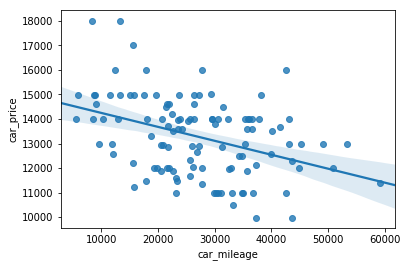

In [4]:

sns.regplot(x='car_mileage',y='car_price',data=selected_data)

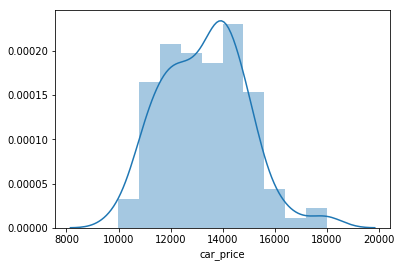

In [5]:
sns.distplot(selected_data.car_price)


#Model Creation and Plotting
    Y ∼ N(μ,σ2)
    μ = α + βX #price_est

    Y ==> Price RV #price_like
    X ==> Mileage 

    α ∼ Normal Dist #intercept_year_overall
    β ∼ Normal Dist #miles_year_overal
    σ ~ Uniform Dist #model_error


In [6]:

from pymc3 import *
num_years = len(selected_data.car_price)

with pm.Model() as price_ymm:
    
        # Stochastic Random Variables with Random Distribution
        intercept_mu = selected_data.car_price.mean()
        intercept_year_mean = pm.Normal('intercept_year_mean', mu=intercept_mu, sd=10000.)
        intercept_year_sd = pm.Normal('intercept_year_sd',mu=intercept_mu, sd=10000.)
        intercept_year_overall = pm.Normal('intercept_year_overall',
                                           mu=intercept_year_mean, sd=intercept_year_sd,shape=num_years)

        miles_year_mean = pm.Normal('miles_year_mean', mu=0, sd=10000.)
        miles_year_sd = pm.Gamma('miles_year_sd', mu=0.0001, sd=10000.)
        #miles distribuitions
        miles_year_overall = pm.Normal('miles_year_overall',mu=miles_year_mean,
                                        sd=miles_year_sd,shape=num_years)
    

        price_est = intercept_year_overall + miles_year_overall * selected_data.car_mileage
        
        # model error
        model_error = pm.Uniform('model_error', lower=0, upper=100000)

        # calculate likelihood
        price_like = pm.Normal('price_like', mu=price_est, sd=model_error, observed=selected_data.car_price)

        # Sampling method to generate posterior sample
        step = pm.Metropolis()
        trace = pm.sample(niter,step=step)

100%|██████████| 10500/10500 [00:20<00:00, 502.76it/s]


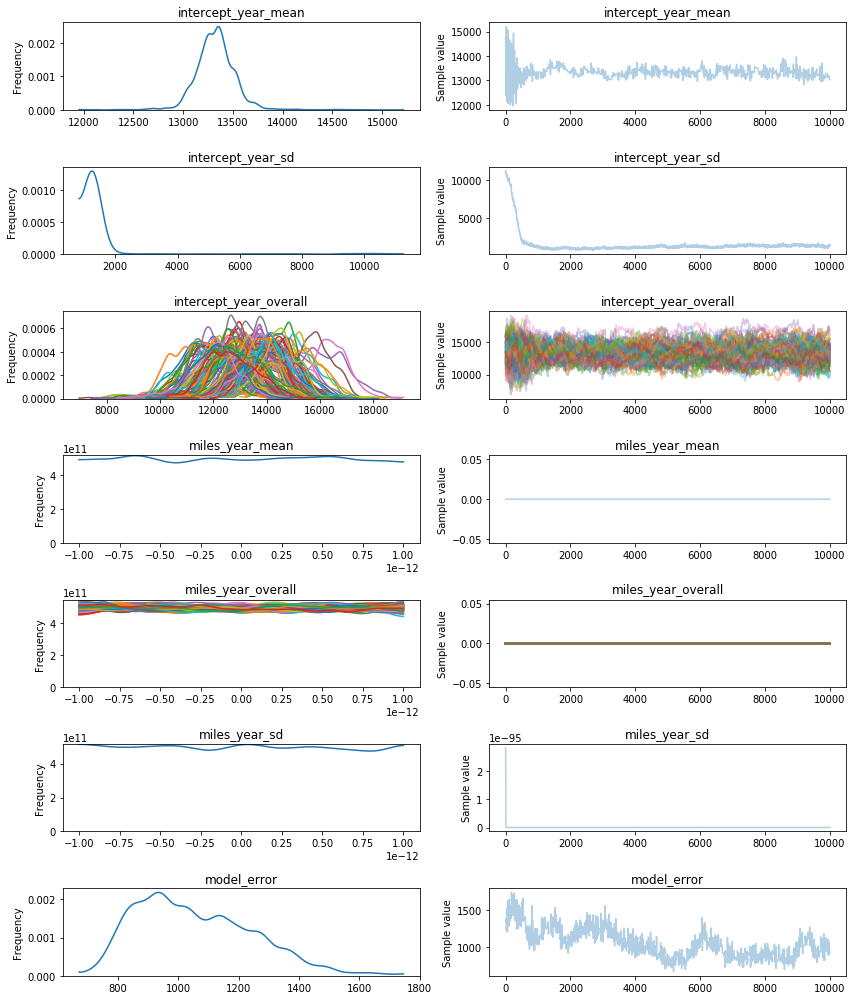

In [7]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();


In [8]:
pm.summary(trace)



intercept_year_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  13326.655        207.867          11.538           [12993.901, 13715.159]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  12982.871      13210.956      13327.871      13433.097      13708.781


intercept_year_sd:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1580.944         1405.427         139.736          [882.797, 2208.686]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  970.310        1162.021       1300.075       1448.763       7193.528


intercept_year_overall:

  Mean             SD             

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  9882.381       10893.240      11399.608      12183.739      13324.446
  9666.425       10495.728      11104.330      11755.298      12994.575
  12348.187      13308.732      13954.661      14500.143      15755.266
  10808.769      12035.264      12537.031      13189.743      14282.878
  12776.944      13871.922      14320.986      14760.010      16201.974
  9559.407       11545.039      12138.552      12684.040      13610.708
  11946.999      13291.942      13817.002      14381.222      15144.842
  12350.031      13399.605      13791.681      14226.003      15209.127
  12679.986      13888.910      14543.306      15092.359      16132.714
  12342.166      13129.791      13608.844      14111.982      15242.321
  11770.421      13249.626      13824.466      14325.115      15677.439
  12439.753      13705.712      14249.346      1483

100%|██████████| 10/10 [00:00<00:00, 59.43it/s]


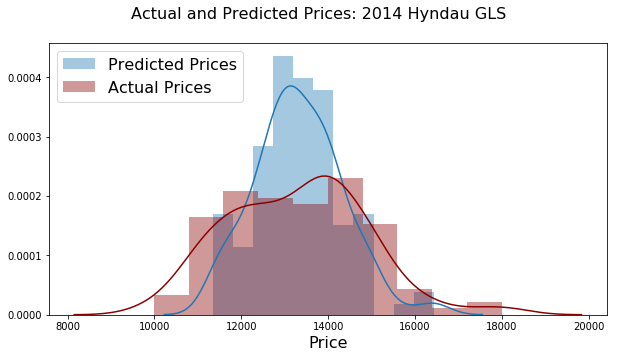

In [9]:
ppc = pm.sample_ppc(trace, model=price_ymm,samples=10)
pred_prices = np.mean(ppc['price_like'],axis=0)

fig,ax = plt.subplots(figsize=(10,5),sharex=True)

fig.suptitle('Actual and Predicted Prices: 2014 Hyndau GLS',fontsize=16)
# predicted
sns.distplot(pred_prices,label='Predicted Prices')

# actual
sns.distplot(selected_data.car_price,color='darkred',label='Actual Prices')
plt.xlabel('Price',fontsize=16)
plt.legend(loc='upper left',fontsize=16)

plt.show()


In [10]:
Reference: https://github.com/clrife/CarPriceAnalysis/blob/master/CarPriceAnalysis_Technical.ipynb

SyntaxError: invalid syntax (<ipython-input-10-c4f75b89a22c>, line 1)